In [46]:
import keras
import itertools
import numpy as np
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix



%matplotlib inline

In [47]:
# image paths
train_path = '/Users/prabaniy/Desktop/potholes/training'
test_path = '/Users/prabaniy/Desktop/potholes/testing'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['potholes', 'not potholes'], batch_size=50)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=['potholes', 'not potholes'], batch_size=50, shuffle=False)

Found 1329 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [48]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

<h1>Build Fine-tuned MobileNet model</h1>

In [49]:
mnet_model = keras.applications.mobilenet.MobileNet()

In [50]:
mnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [51]:
x = mnet_model.layers[-6].output
predictions = Dense(2, activation="softmax")(x)
model = Model(inputs = mnet_model.input, output=predictions)

/Users/prabaniy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [53]:
for layer in model.layers[:-23]:
     layer.trainable = False

In [54]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])

In [55]:
# steps_per_epoch: data per epoch 
data_augmentation = False
epochs = 10
steps_per_epoch = 50
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch,
                   validation_data=test_batches, validation_steps=steps_per_epoch,
                   epochs=epochs, verbose=2, shuffle=True)

Not using data augmentation.
Epoch 1/10
 - 310s - loss: 0.3684 - acc: 0.9063 - val_loss: 5.1060 - val_acc: 0.3200
Epoch 2/10
 - 304s - loss: 0.0848 - acc: 0.9745 - val_loss: 10.6379 - val_acc: 0.3400
Epoch 3/10
 - 290s - loss: 0.0675 - acc: 0.9841 - val_loss: 10.6379 - val_acc: 0.3400
Epoch 4/10
 - 298s - loss: 0.0501 - acc: 0.9881 - val_loss: 3.2796 - val_acc: 0.3200
Epoch 5/10
 - 307s - loss: 0.0407 - acc: 0.9899 - val_loss: 2.9209 - val_acc: 0.3400
Epoch 6/10
 - 318s - loss: 0.0221 - acc: 0.9908 - val_loss: 6.8362 - val_acc: 0.3400
Epoch 7/10
 - 332s - loss: 0.0175 - acc: 0.9952 - val_loss: 2.3453 - val_acc: 0.3200
Epoch 8/10
 - 308s - loss: 0.0158 - acc: 0.9940 - val_loss: 10.6379 - val_acc: 0.3400
Epoch 9/10
 - 311s - loss: 0.0151 - acc: 0.9936 - val_loss: 6.5733 - val_acc: 0.3400
Epoch 10/10
 - 313s - loss: 0.0398 - acc: 0.9892 - val_loss: 8.3652 - val_acc: 0.3200


In [56]:
# Predecting 
test_labels = test_batches.classes


In [64]:
predictions = model.predict_generator(test_batches, steps =3, verbose=0)




In [65]:
print(len(predictions))
print(len(test_labels))

150
150


In [66]:
# confustion matrix
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[  0 100]
 [  0  50]]


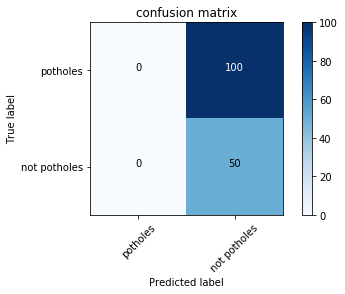

In [67]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_plot_labels = ['potholes', 'not potholes']


plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')

In [63]:
model.save('mobilenet_model.h5')

<h1>END of MobileNet model</h1>